# W266 Project

### Adam Sayre & Erin Werner

Social media has provided the public with a platform for personal expression. This new outlet has given businesses the ability to assess the opinion of the consumer. By automatically detecting the overall feeling behind social media discourse, businesses can make more accurate decisions.

The purpose of this project is to determine the sentiment of tweets, beyond just learning the binary attitude. We want to attempt to detect the actual emotion from the text. This is important because it will provide an even better understanding of what the user is trying to communicate. 

## Exploratory Data Analysis

We will start by examining our dataset. Our data consists of tweets from an emotion dataset from Kaggle (2020), which have been labeled with their corresponding emotion: happy, angry, or disappointed. We chose this data because it includes a cleaned dataset (stripped of retweets, user-tags, and emojis) as well as the uncleaned tweets. 

In [1]:
import numpy as np
import csv
import pandas as pd 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import importlib
import emoji
import tensorflow as tf
import nltk
import re
from nltk.corpus import brown
nltk.download('stopwords')
from nltk.corpus import stopwords
assert(nltk.download("treebank"))
from nltk.corpus import europarl_raw
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erinwerner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/erinwerner/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [2]:
data = pd.read_csv("~/Downloads/dataset(clean).csv") 
data.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...
3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t..."
4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...


In [3]:
len(data)

916575

In [4]:
data.Emotion.unique()

array(['disappointed', 'happy', 'angry'], dtype=object)

As a result, we know that we have three different classes of emotions that serve as our labels. We also have 916,575 different tweets that form our data set. It will also be importnat to know the distribution of emotions within the data, so we will build a histogram.

In [5]:
summary_data = data.groupby('Emotion').count()
summary_data[['Content','Original Content']]

,Content,Original Content
Emotion,,
angry,300990,300990
disappointed,313714,313714
happy,301871,301871


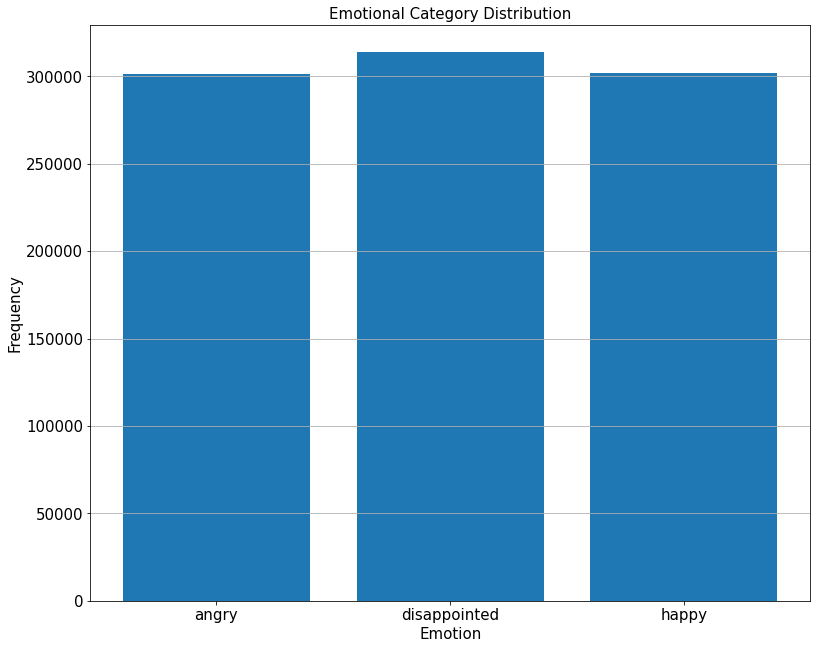

In [6]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_axes([0,0,1,1])
emotions = ['angry', 'disappointed', 'happy']
ax.bar(emotions,summary_data.Content)

plt.grid(axis='y')
plt.xlabel('Emotion',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Emotional Category Distribution',fontsize=15)

plt.show()

From the histogram, we can see that each of the classes are relatively balanced, which means that they are each representated equally in the dataset. This is ideal for building our model as there won't be any significant bias towards one group or another.

We also want to know some of the frequent terms that appear in each of the tweets. These terms could be indicative of the sentiment behind the tweet, meaning that those words would be influential in our model.

In order to get a general idea of what some of these phrases are, we will build a word cloud that displays the most common words from the overall data set. Then, we will generate an individual words cloud for each emotional class. This will provide a more nuianced understanding of terms that expressed the given emotion.

In [7]:
text = ""
for i in data['Content']:
    text +=  ' ' + i

#### General Word Cloud

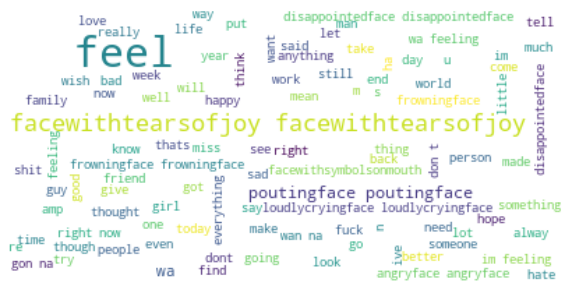

In [8]:
wordcloud_gen = WordCloud(background_color="white",max_words=100).generate(text)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_gen, interpolation='bilinear',)
plt.axis("off")
plt.show()

From this general word cloud, we can see that pairs of emojis are a very common way for users to express themselves in tweets. 

Now, we can take a look at the word cloud for each of the classes.

In [9]:
text_angry = ""
text_disappointed = ""
text_happy = ""

for i in range(0,len(data)):
    emotion = data['Emotion'][i]
    content = data['Content'][i]
    
    if emotion == "angry":
        text_angry += ' ' + content
    elif emotion == "disappointed":
        text_disappointed += ' ' + content
    else:
        text_happy += ' ' + content

#### Angry Word Cloud

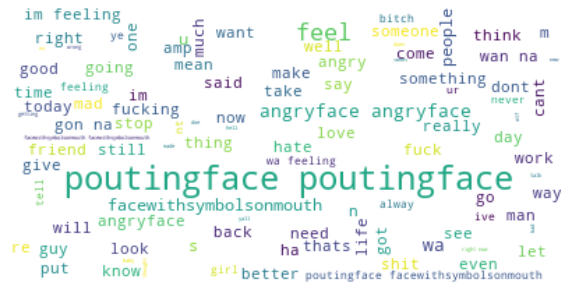

In [10]:
wordcloud_angry = WordCloud(background_color="white",max_words=100).generate(text_angry)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_angry, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the angry word cloud, upset or angry emojis are very common. There are appears to be some profanity and negatively connotated words.

#### Disappointed Word Cloud

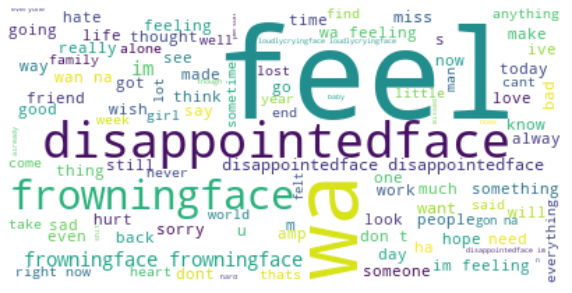

In [11]:
wordcloud_dis = WordCloud(background_color="white",max_words=100).generate(text_disappointed)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_dis, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the disappointed word cloud, the word 'feel' is extremely prominent. This means that it is very common in tweets that express disappointment. We can also see that disappointed or frowning emojis are also frequently used.

#### Happy Word Cloud

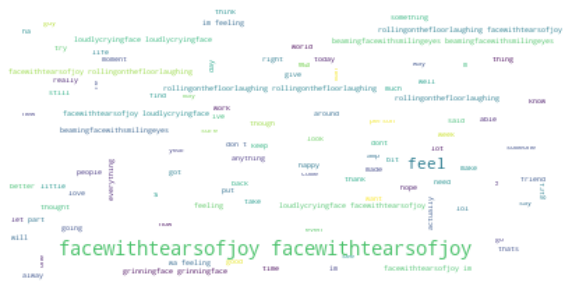

In [12]:
wordcloud_happy = WordCloud(background_color="white",max_words=100).generate(text_happy)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_happy, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the happy word cloud, we can see that most of the terms are smaller of font and are more spread out. This means that there is a wide distribution of terms that make up tweets in the 'happy' classification. As a result, "happy" phrases may not be as influential in our model. Yet, we can still see that smiling and laughing emjois are gnerally more common.

As emojis are clearly a very expressive part of the text in tweets, we want to take a closer look into the emojis that are most frequently used. To start, we can take an overall look of how emojis are represented across different platforms.

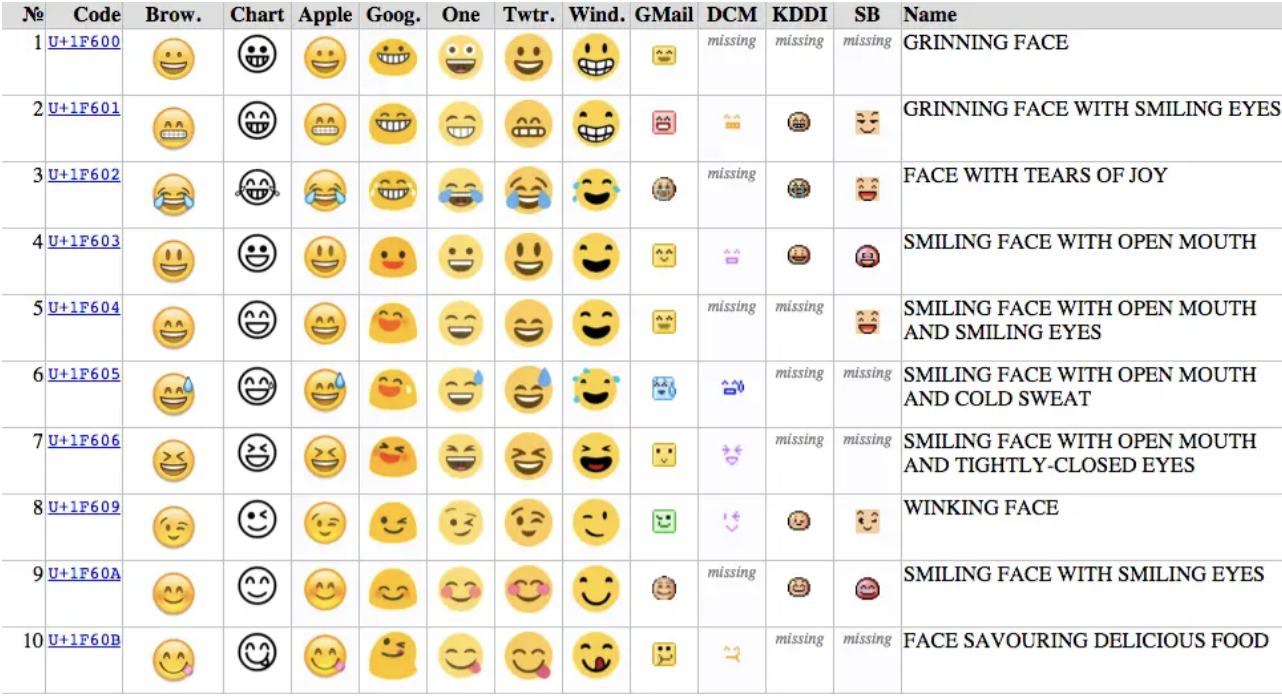

From the chart above, we can see that although there are different visual representations, each emoji has the same descriptions and generally expresses the same sentiment.

Now, we want to understand which emojis are the most common in our dataset.

In [13]:
my_emojis = []

for i in range(0,len(data)):
    text = data['Original Content'][i]
    text = text.replace('\\n',' ')
    text = text.replace('#',' ')
    text = text.replace('&',' ')
    text = text.replace('*',' ')
    text = text.replace('\\',' ')
    text = text.replace('@',' ')
    text = text.split()
    for i in text:
        if i.startswith(":") and i.endswith(":"):
            my_emojis.append(i)

In [14]:
individual_emojis = []

for i in my_emojis:
    text = i.replace(":", " ")
    text = text.split()
    for j in text:
        individual_emojis.append(j)

In [15]:
my_counts = Counter(individual_emojis).most_common(10)

In [16]:
labels = []
counts = []

for i in my_counts:
    labels.append(i[0])
    counts.append(i[1])

In [17]:
emoji_labels = []
for em in labels:
    my_string = ":" + em + ":"
    emoji_labels.append(my_string)

In [18]:
def autolabel(rects,emoji_labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    index = 0
    for rect in rects:
        height = rect.get_height()
        emoji_lab = emoji.emojize(emoji_labels[index])
        ax.annotate(#'{}'.format(emoji_lab),
                    emoji_lab,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index += 1

/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)


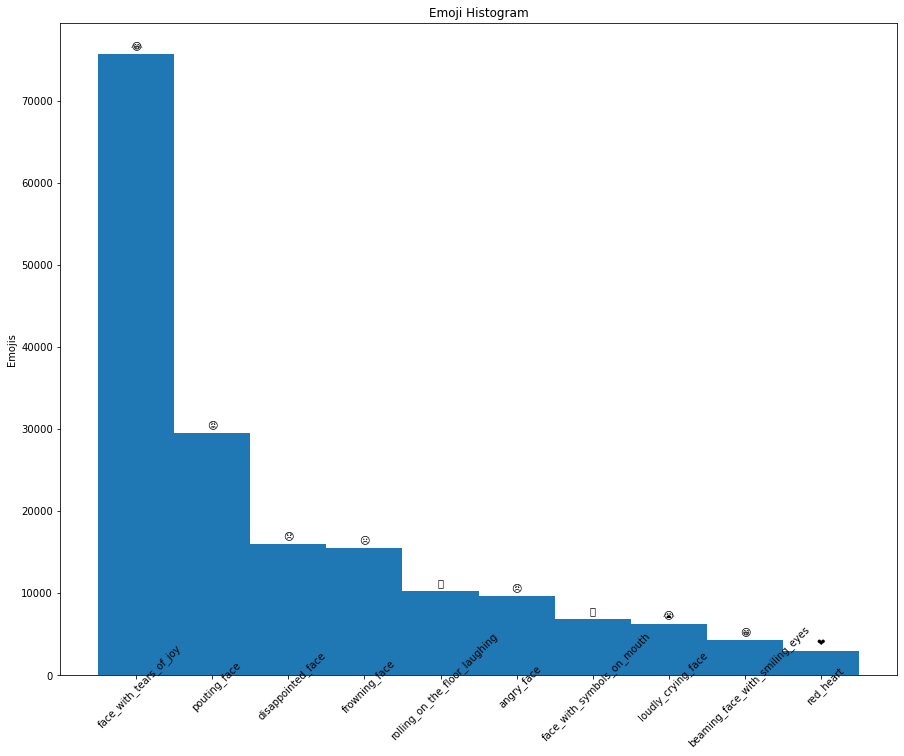

In [19]:
indexes = np.arange(len(labels))
width = 1

fig, ax = plt.subplots(figsize=[15,12])
rect = ax.bar(indexes, counts, width)

ax.set_ylabel('Emojis')
ax.set_title('Emoji Histogram')
ax.set_xticks(indexes,)
ax.set_xticklabels(labels, rotation=45, rotation_mode="anchor")

autolabel(rect,emoji_labels)

From the histogram, we can see that the crying laughing face is by far the most common emoji, followed by the pouting and disappointed face emojis. Although these might be indicative of a certain class, it is important to keep in mind that users may use certain emojis to express different things (i.e. sarcasm).

## Personal Cleaning Method

Although the dataset provides both the original content as well as a cleaned version, we want to apply our own cleaning techniques and compare how they perform in the same models.

So to start we can take a look at the cleaned and original content provided in the dataset.

In [7]:
data.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...
3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t..."
4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...


We can see that the cleaned content does not include any of the website links or user tags. The cleaned content also includes all of the emoji names as a single token.

So, for our personal cleaning technique, we are going to make several changes to the original content. First, we are going to clean the text of special characters, remove stopwords, and lower the text. Then, we are going to replace user tags and website instances with the token 'USERTAGINSTANCE' and 'WEBSITEINSTANCE' respectively. This is because there might be an influence in sentiment related to these Twitter interactions that can be useful in our model. These replacements will allow us to generalize these actions similar to how numbers would be replaced in other NLP tasks. Last, we will split up the emoji name descriptions into individual tokens. This is because each name contains phrases that might be more influential as individual tokens compared to as a single token. Therefore, this cleaning approach will have different results compared to the original data.

In [112]:
data['E_Content'] = data['Original Content']

In [113]:
def preprocess(raw_text):
    stopword_set = set(stopwords.words("english"))
    return " ".join([i for i in re.sub(r'[^a-zA-Z\s]', " ", raw_text).lower().split() if i not in stopword_set])

In [135]:
#for i in range(0,len(data)):
#    tweet = data['E_Content'][i]
#    tweet = re.sub('b\'','',tweet)
#    tweet = re.sub('b\"','',tweet)
#    tweet = re.sub('@[^\s]+','USERTAGINSTANCE',tweet)
#    tweet = re.sub('https','WEBSITEINSTANCE',tweet)
#    tweet = preprocess(tweet)
#    
#    if i%2000 == 0:
#        print(i)
#    
#    data['E_Content'][i] = tweet

In [200]:
#na_index = data_e[pd.isna(data_e['E_Content'])].index
#
#for n in na_index:
#    data_e['E_Content'][n] = data_e['Content'][n]

<ipython-input-200-521bc43e4fbe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_e['E_Content'][n] = data_e['Content'][n]


In [136]:
#data.tail()

,Emotion,Content,Original Content,E_Content
916570,happy,lmaoo facewithtearsofjoy facewithtearsofjoy ex...,"b""@babyboykagiso @pea__nut_ @on_taaa_tile @gos...",usertaginstance usertaginstance usertaginstanc...
916571,disappointed,last day for this peony rain on it way colder ...,b'Last day for this peony rain on its way. Col...,last day peony rain way colder weather well co...
916572,happy,no bird rollingonthefloorlaughing,b'@lynda_lambert @DorsetWildlife No birds :rol...,usertaginstance usertaginstance birds rolling ...
916573,angry,man i had to cancel trip so far this year covi...,b'Man I had to cancel 2 trips so far this year...,man cancel trips far year covid need end mane ...
916574,happy,im really so thankful for this one week break ...,im really so thankful for this one week break ...,im really thankful one week break accounting p...


In [202]:
#data.to_csv("~/Downloads/dataset(clean)_e.csv")

In [144]:
data_e = pd.read_csv("~/Downloads/dataset(clean)_e.csv") 
data_e.head()

,Unnamed: 0,Unnamed: 0.1,Emotion,Content,Original Content,E_Content,label
0,0,0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...,rt usertaginstance usertaginstance oh fuck wro...,0
1,1,1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it,feel shamed,0
2,2,2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...,feeling little bit defeated steps faith would ...,0
3,3,3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t...",usertaginstance imagine reaction guy called jj...,1
4,4,4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...,wouldnt feel burdened would live life testamen...,0


## Logistic Regression Model (Baseline)

Our goal is to build several machine learning model to help us classify which emotion the tweet represent. To start, we will build a logistic regression model to serve as our baseline. It is a simple yet powerful linear model that is a form of regression between 0 and 1 based on the input feature vector, which is useful in classification. This will then be compared to the more advanced methods involving BERT and neural networks.

First, we will run the model on the dataset cleaned content.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#### Original Cleaned Data

In [50]:
possible_labels = data.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'disappointed': 0, 'happy': 1, 'angry': 2}

In [51]:
data['label'] = data.Emotion.replace(label_dict)

In [55]:
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(data.Content.values, data.label.values, test_size=0.3, 
                                                  random_state=42, stratify=data.label.values)

We need to vectorize our input sentences in order to perform the logistic regression.

In [56]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(X_train_c)

X_train_c = vectorizer_c.transform(X_train_c)
X_val_c  = vectorizer_c.transform(X_val_c)
X_train_c

<641602x137520 sparse matrix of type '<class 'numpy.int64'>'
	with 7220343 stored elements in Compressed Sparse Row format>

In [57]:
classifier_c = LogisticRegression(max_iter = 1000)
classifier_c.fit(X_train_c, y_train_c)
score_c = classifier_c.score(X_val_c, y_val_c)

print("Accuracy:", score_c)

Accuracy: 0.8948878617173323


Our logistic regression model is 89% accurate, making it a good baseline model.

In [58]:
y_pred_c = classifier_c.predict(X_val_c)
f1_score_c = f1_score(y_val_c, y_pred_c, average='weighted')

print("F1 Score:", f1_score_c)

F1 Score: 0.8953779925281025


#### Original Uncleaned Data

In [59]:
data["Original_Content"] = data["Original Content"]

In [60]:
X_train_oc, X_val_oc, y_train_oc, y_val_oc = train_test_split(data.Original_Content.values, data.label.values, 
                                                  test_size=0.3, random_state=42, stratify = data.label.values)

In [61]:
vectorizer_oc = CountVectorizer()
vectorizer_oc.fit(X_train_oc)

X_train_oc = vectorizer_oc.transform(X_train_oc)
X_val_oc  = vectorizer_oc.transform(X_val_oc)
X_train_oc

<641602x481718 sparse matrix of type '<class 'numpy.int64'>'
	with 8042805 stored elements in Compressed Sparse Row format>

In [62]:
classifier_oc = LogisticRegression(max_iter = 1000)
classifier_oc.fit(X_train_oc, y_train_oc)
score_oc = classifier_oc.score(X_val_oc, y_val_oc)

print("Accuracy:", score_oc)

Accuracy: 0.9000338215024748


The uncleaned data actually recieved a better accuracy score of 90%. 

In [63]:
y_pred_oc = classifier_oc.predict(X_val_oc)
f1_score_oc = f1_score(y_val_oc, y_pred_oc, average='weighted')

print("F1 Score:", f1_score_oc)

F1 Score: 0.9004368911378267


Now, we will run the same logistic regression model on our personally cleaned tweets.

In [64]:
possible_labels_e = data_e.Emotion.unique()

label_dict_e = {}
for index, possible_label in enumerate(possible_labels_e):
    label_dict_e[possible_label] = index
label_dict_e

{'disappointed': 0, 'happy': 1, 'angry': 2}

In [65]:
data_e['label'] = data_e.Emotion.replace(label_dict_e)

In [66]:
X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(data_e.E_Content.values, data_e.label.values, 
                                                  test_size=0.30,random_state=42, stratify=data_e.label.values)

In [67]:
vectorizer_e = CountVectorizer()
vectorizer_e.fit(X_train_e)

X_train_e = vectorizer_e.transform(X_train_e)
X_val_e  = vectorizer_e.transform(X_val_e)
X_train_e

<641602x248526 sparse matrix of type '<class 'numpy.int64'>'
	with 5641629 stored elements in Compressed Sparse Row format>

In [68]:
classifier_e = LogisticRegression(max_iter = 1000)
classifier_e.fit(X_train_e, y_train_e)
score_e = classifier_e.score(X_val_e, y_val_e)

print("Accuracy:", score_e)

Accuracy: 0.894051415957203


Our personal cleaning method performed roughly the same as the original cleaned dataset.

In [69]:
y_pred_e = classifier_e.predict(X_val_e)
f1_score_e = f1_score(y_val_e, y_pred_e, average='weighted')

print("F1 Score:", f1_score_e)

F1 Score: 0.8944883271846511


In [73]:
lr_acc = [score_oc, score_c, score_e]
lr_f1 = [f1_score_oc, f1_score_c, f1_score_e]
lr_values = ['Orig. Uncleaned', 'Orig. Cleaned', 'Custom Cleaned']
lr_df = pd.DataFrame()
lr_df['Cleaning Method'] = lr_values
lr_df['Accuracy'] = lr_acc
lr_df['F1 Score'] = lr_f1
lr_df

,Cleaning Method,Accuracy,F1 Score
0,Orig. Uncleaned,0.900034,0.900437
1,Orig. Cleaned,0.894888,0.895378
2,Custom Cleaned,0.894051,0.894488


## BERT 

In [75]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import random

In [125]:
data['Emotion'].value_counts()

disappointed    313714
happy           301871
angry           300990
Name: Emotion, dtype: int64

In [126]:
possible_labels = data.Emotion.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'disappointed': 0, 'happy': 1, 'angry': 2}

In [127]:
data['label'] = data.Emotion.replace(label_dict)

In [139]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, data.label.values, test_size=0.99, 
                                                  random_state=42, stratify=data.label.values)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, 
                                                  random_state=42, stratify=y_train)

In [140]:
data['data_type'] = ['not_set']*data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

data.groupby(['Emotion', 'label', 'data_type']).count()

Content  Original Content  Original_Content
Emotion      label data_type                                             
angry        2     not_set     297980            297980            297980
                   train         1505              1505              1505
                   val           1505              1505              1505
disappointed 0     not_set     310577            310577            310577
                   train         1568              1568              1568
                   val           1569              1569              1569
happy        1     not_set     298853            298853            298853
                   train         1509              1509              1509
                   val           1509              1509              1509

In [130]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#### Original Cleaned Data

In [97]:
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

In [98]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [99]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict),
                                                      output_attentions=False,output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [92]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [93]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
                  
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [19]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [20]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
def evaluate(dataloader_val):

    model.eval()  
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)     
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [ ]:
#1 epoch for 1500 data took 2 hr 17 min
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
             

In [25]:
tqdm.write(f'\nEpoch {epoch}')
    
loss_train_avg = loss_train_total/len(dataloader_train)            
tqdm.write(f'Training loss: {loss_train_avg}')

val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

bert_f1_c = val_f1
bert_tr_loss_c = loss_train_avg
bert_val_loss_c = val_loss


Epoch 1
Training loss: 0.6300952161655576
Validation loss: 0.47935207706131894
F1 Score (Weighted): 0.8456785244525246


In [157]:
#bert_f1_c = 0.8456785244525246
#bert_tr_loss_c = 0.6300952161655576
#bert_val_loss_c = 0.47935207706131894

F1 Score of 0.85!

#### Original Uncleaned Data

In [131]:
encoded_data_train_oc = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].Original_Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val_oc = tokenizer.batch_encode_plus(
    data[data.data_type=='val'].Original_Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

In [132]:
input_ids_train_oc = encoded_data_train_oc['input_ids']
attention_masks_train_oc = encoded_data_train_oc['attention_mask']
labels_train_oc = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val_oc = encoded_data_val_oc['input_ids']
attention_masks_val_oc = encoded_data_val_oc['attention_mask']
labels_val_oc = torch.tensor(data[data.data_type=='val'].label.values)

dataset_train_oc = TensorDataset(input_ids_train_oc, attention_masks_train_oc, labels_train_oc)
dataset_val_oc = TensorDataset(input_ids_val_oc, attention_masks_val_oc, labels_val_oc)

In [133]:
dataloader_train_oc = DataLoader(dataset_train_oc, sampler=RandomSampler(dataset_train_oc), batch_size=batch_size)
dataloader_validation_oc = DataLoader(dataset_val_oc, sampler=SequentialSampler(dataset_val_oc),batch_size=batch_size)

In [134]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_oc)*epochs)

In [135]:
for epoch in tqdm(range(1, epochs+1)):   
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_oc, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)     
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()       
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})            

In [136]:
tqdm.write(f'\nEpoch {epoch}')
    
loss_train_avg = loss_train_total/len(dataloader_train)            
tqdm.write(f'Training loss: {loss_train_avg}')

val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

bert_f1_oc = val_f1
bert_tr_loss_oc = loss_train_avg
bert_val_loss_oc = val_loss


Epoch 1
Training loss: 0.9637803447012808
Validation loss: 0.9272041449359819
F1 Score (Weighted): 0.5696324833879419


In [158]:
#bert_tr_loss_oc = 0.9637803447012808
#bert_val_loss_oc = 0.9272041449359819

#### Custom Cleaned Data

In [145]:
possible_labels_e = data_e.Emotion.unique()

label_dict_e = {}
for index, possible_label in enumerate(possible_labels_e):
    label_dict_e[possible_label] = index
label_dict_e

{'disappointed': 0, 'happy': 1, 'angry': 2}

In [146]:
data_e['label'] = data_e.Emotion.replace(label_dict_e)

In [147]:
X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(data_e.index.values, data_e.label.values, test_size=0.999, 
                                                  random_state=42, stratify=data_e.label.values)

X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(X_train_e, y_train_e, test_size=0.5, 
                                                  random_state=42, stratify=y_train_e)

In [149]:
data__e = pd.DataFrame()
data__e['Emotion'] = data_e['Emotion']
data__e['label'] = data_e['label']
data__e['E_Content'] = data_e['E_Content']

data__e['data_type'] = ['not_set']*data__e.shape[0]

data__e.loc[X_train_e, 'data_type'] = 'train'
data__e.loc[X_val_e, 'data_type'] = 'val'

data__e.groupby(['Emotion', 'label', 'data_type']).count()

E_Content
Emotion      label data_type           
angry        2     not_set       300689
                   train            151
                   val              150
disappointed 0     not_set       313401
                   train            156
                   val              157
happy        1     not_set       301569
                   train            151
                   val              151

In [150]:
encoded_data_train_e = tokenizer.batch_encode_plus(
    data__e[data__e.data_type=='train'].E_Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val_e = tokenizer.batch_encode_plus(
    data__e[data__e.data_type=='val'].E_Content.values, 
    add_special_tokens=True, 
    truncation=True,
    padding=True,
    return_attention_mask=True, 
    max_length=256, 
    return_tensors='pt'
)

In [151]:
input_ids_train_e = encoded_data_train_e['input_ids']
attention_masks_train_e = encoded_data_train_e['attention_mask']
labels_train_e = torch.tensor(data__e[data__e.data_type=='train'].label.values)

input_ids_val_e = encoded_data_val_e['input_ids']
attention_masks_val_e = encoded_data_val_e['attention_mask']
labels_val_e = torch.tensor(data__e[data__e.data_type=='val'].label.values)

dataset_train_e = TensorDataset(input_ids_train_e, attention_masks_train_e, labels_train_e)
dataset_val_e = TensorDataset(input_ids_val_e, attention_masks_val_e, labels_val_e)

In [152]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict_e),
                                                      output_attentions=False,output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [153]:
dataloader_train_e = DataLoader(dataset_train_e, sampler=RandomSampler(dataset_train_e), batch_size=batch_size)
dataloader_validation_e = DataLoader(dataset_val_e, sampler=SequentialSampler(dataset_val_e), batch_size=batch_size)

In [154]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
                  
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train_e)*epochs)

In [155]:
for epoch in tqdm(range(1, epochs+1)):   
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train_e, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)     
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()       
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})            

In [156]:
tqdm.write(f'\nEpoch {epoch}')
    
loss_train_avg = loss_train_total/len(dataloader_train)            
tqdm.write(f'Training loss: {loss_train_avg}')

val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

bert_f1_e = val_f1
bert_tr_loss_e = loss_train_avg
bert_val_loss_e = val_loss


Epoch 1
Training loss: 1.0519642128663904
Validation loss: 1.102649312782911
F1 Score (Weighted): 0.3038213838629078


In [159]:
#bert_tr_loss_e = 1.0519642128663904
#bert_val_loss_e = 1.102649312782911

In [160]:
b_f1 = [bert_f1_oc, bert_f1_c, bert_f1_e]
b_tr_loss = [bert_tr_loss_oc, bert_tr_loss_c, bert_tr_loss_e]
b_val_loss = [bert_val_loss_oc, bert_val_loss_c, bert_val_loss_e]
b_values = ['Orig. Uncleaned', 'Orig. Cleaned', 'Custom Cleaned']
b_df = pd.DataFrame()
b_df['Cleaning Method'] = b_values
b_df['F1 Score'] = b_f1
b_df['Training Loss'] = b_tr_loss
b_df['Validation Loss'] = b_val_loss
b_df

,Cleaning Method,F1 Score,Training Loss,Validation Loss
0,Orig. Uncleaned,0.569632,0.963780,0.927204
1,Orig. Cleaned,0.845679,0.630095,0.479352
2,Custom Cleaned,0.303821,1.051964,1.102649


## CNN Model

In [250]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session

### Shallow CNN 

#### Original Cleaned Data

In [251]:
input_dim = X_train_c.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [252]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                1375210   
_________________________________________________________________
dense_3 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 1,377,141
Trainable params: 1,377,141
Non-trainable params: 0
_________________________________________________________________


In [253]:
clear_session()

In [254]:
history = model.fit(X_train_c, y_train_c,epochs=10,verbose=False,
                     validation_data=(X_val_c, y_val_c),batch_size=10)

In [255]:
cnn_loss_c, cnn_accuracy_c = model.evaluate(X_train_c, y_train_c, verbose=False)
print("Training Accuracy: {:.4f}".format(cnn_accuracy_c))
cnn_loss_c_val, cnn_accuracy_c_val = model.evaluate(X_val_c, y_val_c, verbose=False)
print("Validation Accuracy:  {:.4f}".format(cnn_accuracy_c_val))

Training Accuracy: 0.4395
Validation Accuracy:  0.4380


In [256]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

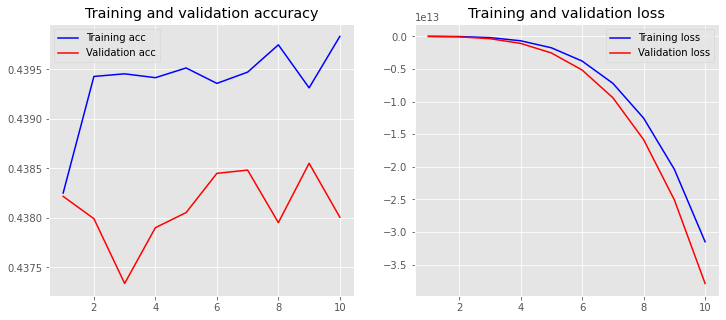

In [257]:
plot_history(history)

#### Original Uncleaned Data

In [258]:
input_dim = X_train_oc.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [259]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                4817190   
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 4,819,121
Trainable params: 4,819,121
Non-trainable params: 0
_________________________________________________________________


In [260]:
clear_session()

In [261]:
history = model.fit(X_train_oc, y_train_oc,epochs=10,verbose=False,
                     validation_data=(X_val_oc, y_val_oc),batch_size=10)

KeyboardInterrupt: 

In [ ]:
cnn_loss_oc, cnn_accuracy_oc = model.evaluate(X_train_oc, y_train_oc, verbose=False)
print("Training Accuracy: {:.4f}".format(cnn_accuracy_oc))
cnn_loss_oc_val, cnn_accuracy_oc_val = model.evaluate(X_val_oc, y_val_oc, verbose=False)
print("Validation Accuracy:  {:.4f}".format(cnn_accuracy_oc_val))

In [ ]:
plot_history(history)

#### Custom Cleaned Data

In [263]:
X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(data_e.E_Content.values, data_e.label.values, 
                                                  test_size=0.30,random_state=42, stratify=data_e.label.values)
vectorizer_e = CountVectorizer()
vectorizer_e.fit(X_train_e)

X_train_e = vectorizer_e.transform(X_train_e)
X_val_e  = vectorizer_e.transform(X_val_e)
X_train_e

<641602x248526 sparse matrix of type '<class 'numpy.int64'>'
	with 5641629 stored elements in Compressed Sparse Row format>

In [264]:
input_dim = X_train_e.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [265]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2485270   
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 2,487,201
Trainable params: 2,487,201
Non-trainable params: 0
_________________________________________________________________


In [266]:
history = model.fit(X_train_e, y_train_e,epochs=10,verbose=False,
                     validation_data=(X_val_e, y_val_e),batch_size=10)

KeyboardInterrupt: 

In [ ]:
cnn_loss_e, cnn_accuracy_e = model.evaluate(X_train_e, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(cnn_accuracy_e))
cnn_loss_e_val, cnn_accuracy_e_val = model.evaluate(X_val_e, y_val_e, verbose=False)
print("Validation Accuracy:  {:.4f}".format(cnn_accuracy_e_val))

In [ ]:
plot_history(history)

### Deep CNN 

#### Original Cleaned Data

In [267]:
from pickle import load
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

In [268]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [269]:
X_train_tc, X_val_tc, y_train_tc, y_val_tc = train_test_split(data.Content.values, data.label.values, test_size=0.98, 
                                                  random_state=42, stratify=data.label.values)

X_train_tc, X_val_tc, y_train_tc, y_val_tc = train_test_split(X_train_tc, y_train_tc, test_size=0.5, 
                                                  random_state=42, stratify=y_train_tc)

In [270]:
# create tokenizer
tokenizer = create_tokenizer(X_train_tc)
# calculate max document length
length = max_length(X_train_tc)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trainX_tc = encode_text(tokenizer, X_train_tc, length)
valX_tc = encode_text(tokenizer, X_val_tc, length)
print(trainX_tc.shape, valX_tc.shape)

Max document length: 119
Vocabulary size: 11436
(9165, 119) (9166, 119)


In [271]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = layers.Input(shape=(length,))
    embedding1 = layers.Embedding(vocab_size, 100)(inputs1)
    conv1 = layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = layers.Dropout(0.5)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = layers.Flatten()(pool1)
    # channel 2
    inputs2 = layers.Input(shape=(length,))
    embedding2 = layers.Embedding(vocab_size, 100)(inputs2)
    conv2 = layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = layers.Dropout(0.5)(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = layers.Flatten()(pool2)
    # channel 3
    inputs3 = layers.Input(shape=(length,))
    embedding3 = layers.Embedding(vocab_size, 100)(inputs3)
    conv3 = layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = layers.Dropout(0.5)(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = layers.Flatten()(pool3)
    # merge
    merged = layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = layers.Dense(10, activation='relu')(merged)
    outputs = layers.Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    #plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [272]:
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX_tc,trainX_tc,trainX_tc], y_train_tc, epochs=5, batch_size=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 119)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 119)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 119)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 119, 100)     1143600     input_1[0][0]                    
______________________________________________________________________________________________

#### Original Uncleaned Data

In [273]:
X_train_toc, X_val_toc, y_train_toc, y_val_toc = train_test_split(data.Original_Content.values, 
                                                  data.label.values, test_size=0.98, 
                                                  random_state=42, stratify=data.label.values)

X_train_toc, X_val_toc, y_train_toc, y_val_toc = train_test_split(X_train_toc, y_train_toc, test_size=0.5, 
                                                  random_state=42, stratify=y_train_toc)

In [274]:
# create tokenizer
tokenizer = create_tokenizer(X_train_toc)
# calculate max document length
length = max_length(X_train_toc)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trainX_toc = encode_text(tokenizer, X_train_toc, length)
valX_toc = encode_text(tokenizer, X_val_toc, length)
print(trainX_toc.shape, valX_toc.shape)

Max document length: 59
Vocabulary size: 20405
(9165, 59) (9166, 59)


In [275]:
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX_toc,trainX_toc,trainX_toc], y_train_toc, epochs=5, batch_size=10)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 59, 100)      2040500     input_4[0][0]                    
____________________________________________________________________________________________

#### Custom Cleaned Data

In [276]:
X_train_te, X_val_te, y_train_te, y_val_te = train_test_split(data_e.E_Content.values, 
                                                  data_e.label.values, test_size=0.98, 
                                                  random_state=42, stratify=data_e.label.values)

X_train_te, X_val_te, y_train_te, y_val_te = train_test_split(X_train_te, y_train_te, test_size=0.5, 
                                                  random_state=42, stratify=y_train_te)

In [277]:
# create tokenizer
tokenizer = create_tokenizer(X_train_te)
# calculate max document length
length = max_length(X_train_te)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trainX_te = encode_text(tokenizer, X_train_te, length)
valX_te = encode_text(tokenizer, X_val_te, length)
print(trainX_te.shape, valX_te.shape)

Max document length: 243
Vocabulary size: 14409
(9165, 243) (9166, 243)


In [278]:
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX_te,trainX_te,trainX_te], y_train_te, epochs=5, batch_size=10)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 243)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 243)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 243)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 243, 100)     1440900     input_7[0][0]                    
____________________________________________________________________________________________

## BERT Encoding & CNN

In [236]:
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [238]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [239]:
labels_train

tensor([1, 1, 1,  ..., 2, 2, 2])

In [240]:
train_loader = DataLoader(dataset_train)
val_loader = DataLoader(dataset_val)

In [241]:
# Sample configuration:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [242]:
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [243]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [244]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [245]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

In [246]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [247]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=100000,
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_loader, val_loader, epochs=1)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


IndexError: Target 2 is out of bounds.

In [248]:
input_ids_train.shape

torch.Size([4582, 256])

In [233]:
cnn_rand(input_ids_train)

tensor([[-1.1318,  1.1345],
        [-1.1202,  1.6747],
        [-1.0604,  0.8180],
        ...,
        [-0.2841,  0.0344],
        [-0.2640,  0.1141],
        [-0.5127,  0.2143]], grad_fn=<AddmmBackward>)

In [234]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

logits = cnn_rand(input_ids_train)
loss_fn(logits, labels_train)

IndexError: Target 2 is out of bounds.

In [235]:
logits.shape

torch.Size([4582, 2])